In [1]:
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam

using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz

using LabelledArrays
using DifferentialEquations
using Plots

In [2]:
# We use  functorial semantics to model the electricity sector system in the Netherlands.
# We define a diagram of systems (the composition syntax) that is the architecture of the composition.
# Then, we apply behaviors of the individual parts of the system to the architecture.

# A wiring diagram has outer inports and outports which define the interface of target system. 
# Then we add the boxes and wires to the diagram and visualize the result.
ElecSys = WiringDiagram([], [:ec_machine])

# Define the composition pattern by adding boxes and specify what the ...   
ec = add_box!(ElecSys, Box(:ec_machine, [:a], [:a]))
eg = add_box!(ElecSys, Box(:eg_machine, [:a], [:a]))
ed = add_box!(ElecSys, Box(:ed_machine, [:a], [:a]))
gdp = add_box!(ElecSys, Box(:gdp_machine, [:a], [:a]))
pop = add_box!(ElecSys, Box(:pop_machine, [:a], [:a]))

5

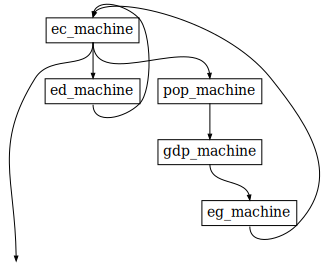

In [3]:
add_wires!(ElecSys, [
    ## net inputs
    #(input_id(ElecSys), 1) => (ed, 1),

    ## reinforcing loop - 1
    (eg, 1) => (ec, 1),
    (gdp, 1) => (eg, 1),
    (pop, 1) => (gdp, 1),
    (ec, 1) => (pop, 1),
        
    ## balancing loop - 1
    (ec, 1) => (ed, 1),
    (ed, 1) => (ec, 1),

    ## net output
    (ec, 1) => (output_id(ElecSys), 1)
])

to_graphviz(ElecSys)

In [4]:
# Define the primitive systems
dt_ec(u, x, p, t) = [u[1] + p.alpha*u[1]*x[1] - p.epsilon*u[1]*x[1]];
dt_eg(u, x, p, t) = [u[1] + p.beta*u[1]*x[1]];
dt_ed(u, x, p, t) = [u[1] + p.beta*u[1]*x[1]];

dt_gdp(u, x, p, t) = [u[1] + p.gamma*u[1]*x[1]];
dt_pop(u, x, p, t) = [1*u[1] + p.delta*u[1]*x[1]];

In [5]:
# ContinuousMachine{T}(ninputs, nstates, noutputs, f, r)
# The dynamics function f defines an ODE \dot u(t) = f(u(t),x(t),p,t)
# where u is the state and x captures the exogenous variables, p the parameters, and t the time.
ec_machine = ContinuousMachine{Float64}(1,1,1, dt_ec, (u, p, t) -> u)
eg_machine = ContinuousMachine{Float64}(1,1,1, dt_eg, (u, p, t) -> u)
ed_machine = ContinuousMachine{Float64}(1,1,1, dt_ed, (u, p, t) -> u)
gdp_machine = ContinuousMachine{Float64}(1,1,1, dt_gdp, (u, p, t) -> u)
pop_machine = ContinuousMachine{Float64}(1,1,1, dt_pop, (u, p, t) -> u)

ContinuousMachine(ℝ^1 × ℝ^1 → ℝ^1)

In [6]:
# Compose
electricity_sector_system = oapply(
    ElecSys,
    [ec_machine, eg_machine, ed_machine, gdp_machine, pop_machine]
);

In [7]:
# Lastly, we compute and plot the solution.

# initial values
params = LVector(
    alpha=0.3,
    beta=0.015,
    gamma=0.015,
    delta=0.7,
    epsilon=0.3,
);

u0 = [1.0, 2.0, 1.0, 1.0, 1.0];
tspan = (0.0, 4.0);

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/christovis/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351


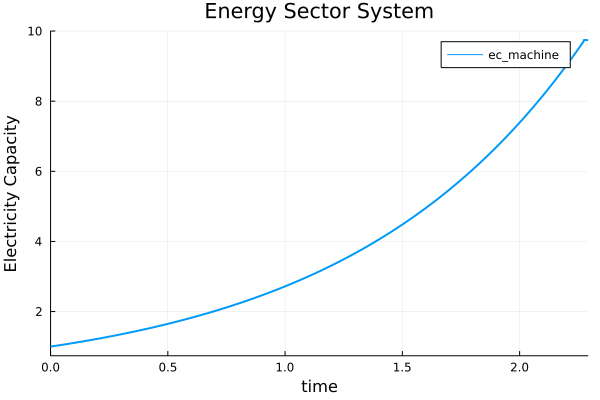

In [8]:
prob = ODEProblem(electricity_sector_system, u0, tspan, params);
sol = solve(prob, Tsit5());

plot(
    sol, electricity_sector_system, params,
    lw=2,
    title="Energy Sector System",
    xlabel="time",
    ylabel="Electricity Capacity",
)